In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(1)

In [2]:
baseline_results = pd.read_csv('baseline_model_results/results.csv')

In [3]:
rl_results_files = ['rl_model_results/' + x for x in os.listdir('rl_model_results') if '.txt' in x]

parsed_results = []

for file in rl_results_files:
    with open(file, 'r') as f:
        results = f.readlines()

    for line in results:
        split_line = line.replace(' ', '').replace('\n', '').split('|')
        values = [x.split(':')[1] for x in split_line]
        parsed_results.append(values)

rl_results = pd.DataFrame(parsed_results, columns=['file', 'step', 'cash_balance', 'n_shares', 'reward', 'account_value','action_type', 'amount'])

rl_results['action_type'] = rl_results['action_type'].str.replace(',', '')

int_cols = ['step', 'action_type', 'amount', 'n_shares']
float_cols = ['cash_balance', 'reward', 'account_value']

rl_results[int_cols] = rl_results[int_cols].astype(int)
rl_results[float_cols] = rl_results[float_cols].astype(float)

In [4]:
pal = sns.color_palette('deep', 2)

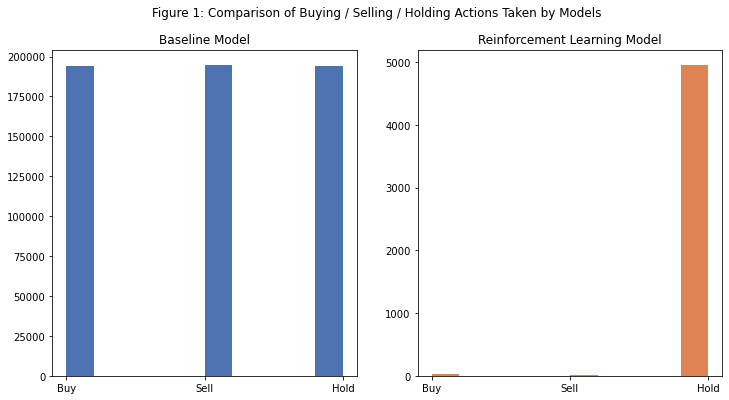

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Figure 1: Comparison of Buying / Selling / Holding Actions Taken by Models')

ax0 = axes[0]
ax1 = axes[1]

h0 = ax0.hist(baseline_results['action_type'], color=pal[0])
t0 = ax0.set_title('Baseline Model')
tks0 = ax0.axes.set_xticks([0,1,2])
tk_ls0 = ax0.set_xticklabels(['Buy', 'Sell', 'Hold'])

h1 = ax1.hist(rl_results['action_type'], color=pal[1])
t1 = ax1.set_title('Reinforcement Learning Model')
tks1 = ax1.axes.set_xticks([0,1,2])
tk_ls1 = ax1.set_xticklabels(['Buy', 'Sell', 'Hold'])

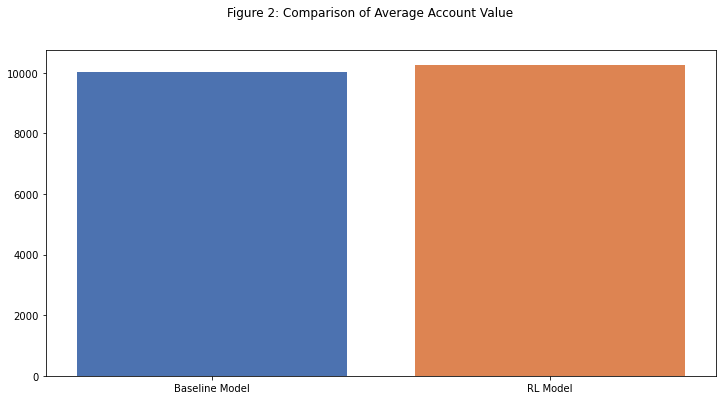

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Figure 2: Comparison of Average Account Value')

baseline_mean = baseline_results['account_value'].mean()
rl_mean = rl_results['account_value'].mean()

b = ax.bar(['Baseline Model', 'RL Model'], [baseline_mean, rl_mean], color=pal)

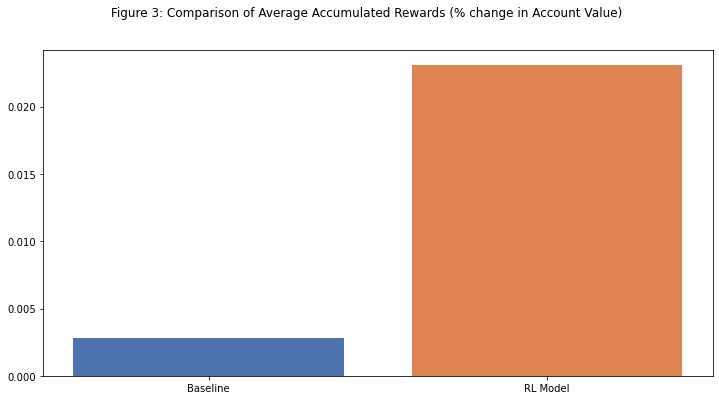

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Figure 3: Comparison of Average Accumulated Rewards (% change in Account Value)')

baseline_mean = baseline_results.groupby('run_number')['reward'].sum().mean()
rl_mean = rl_results.groupby('file')['reward'].sum().mean()

b = ax.bar(['Baseline', 'RL Model'], [baseline_mean, rl_mean], color=pal)

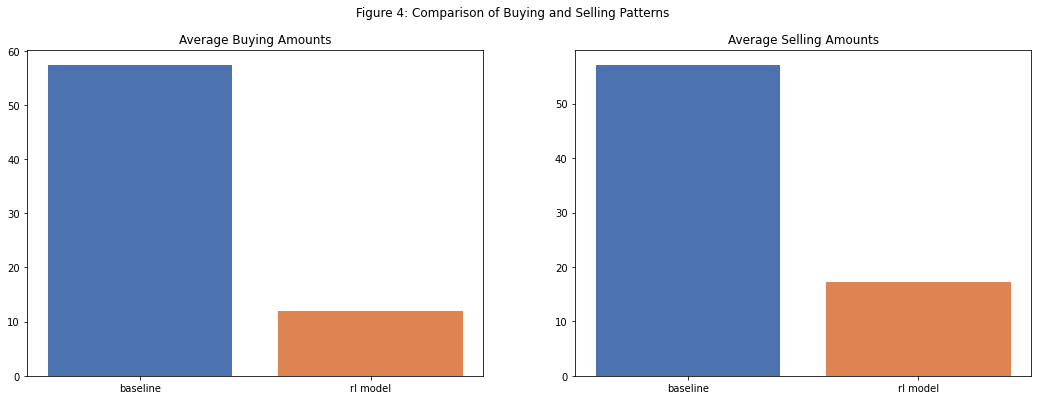

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Figure 4: Comparison of Buying and Selling Patterns')

ax0 = axes[0]
ax1 = axes[1]

baseline_mean_buying = baseline_results.loc[baseline_results['action_type'] == 0, 'amount'].mean()
rl_mean_buying = rl_results.loc[rl_results['action_type'] == 0, 'amount'].mean()
b0 = ax0.bar(['baseline', 'rl model'], [baseline_mean_buying, rl_mean_buying], color=pal)
t0 = ax0.set_title('Average Buying Amounts')

baseline_mean_selling = baseline_results.loc[baseline_results['action_type'] == 1, 'amount'].mean()
rl_mean_selling = rl_results.loc[rl_results['action_type'] == 1, 'amount'].mean()
b1 = ax1.bar(['baseline', 'rl model'], [baseline_mean_selling, rl_mean_selling], color=pal)
t1 = ax1.set_title('Average Selling Amounts')

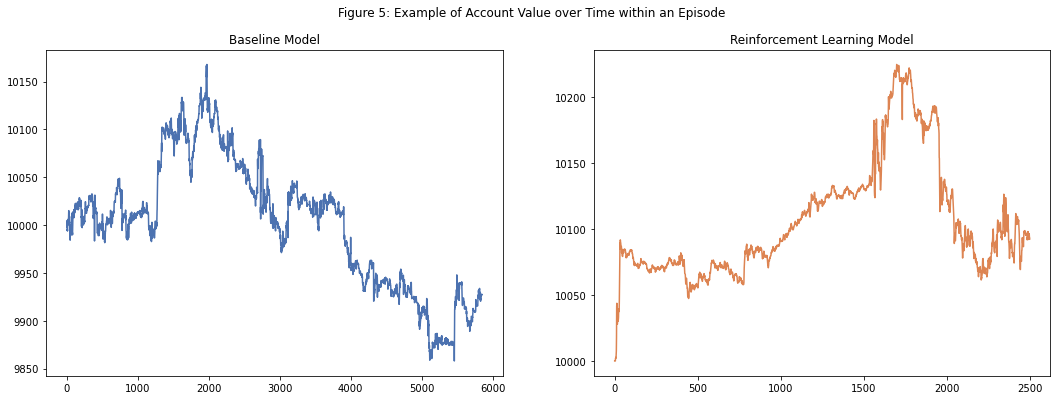

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Figure 5: Example of Account Value over Time within an Episode')

ax0 = axes[0]
ax1 = axes[1]

rand_baseline_episode = np.random.choice(baseline_results['run_number'].unique())
rand_baseline_subset = baseline_results.loc[baseline_results['run_number'] == rand_baseline_episode]

lp0 = ax0.plot(range(rand_baseline_subset.shape[0]), rand_baseline_subset['account_value'], color=pal[0])
t0 = ax0.set_title('Baseline Model')

rand_rl_episode = np.random.choice(rl_results['file'].unique())
rand_rl_subset = rl_results.loc[rl_results['file'] == rand_rl_episode]

lp1 = ax1.plot(range(rand_rl_subset.shape[0]), rand_rl_subset['account_value'], color=pal[1])
t1 = ax1.set_title('Reinforcement Learning Model')

# Overview

The goal of the project is to design a model that can effectively trade shares of US retail companies in the 15-day trading period surrounding their earnings reports. Observations are fed to the models at one-minute intervals where the model can decide to buy or sell shares, or continue to hold its current position. Each of these periods can be thought of as an individual "episode". To this end, a reinforcement learning (RL) model was tested against a baseline model to gauge its performance. Each model begins an episode with $10,000 and this figure is updated based on its decisions. Because the goal of this

#### Note:
Regarding the component of this assignment to perform feature engineering, as the target model in this case is a neural network, any feature engineeering should be handled natively by the layers of the network.  

# Environment

The environment and its states consists of four components:
<ol>
    <li>The one-minute values of for open, high, low, close and volume for the stock's shares</li>
    <li>Analyst estimates and their summary statistics for this earnings date</li>
    <li>The cash balance and number of shares held in the account
    <li>The acceptable list of actions based on the accounts' position (e.g. an account with 50 shares cannot sell >50 shares</li>
</ol>
 
# Model Design

The baseline and RL models, respectively, are designed as follows: 
<ol>
    <li>At each timestep, the baseline model randomly selects an action to buy, sell or hold its current position. Based on this choice, it randomly selects an amount of shares to buy or sell based on its current cash balance and number of shares (i.e. the model can only sell as many shares as it actually has in its account. This process is similar to a random walk and would represent an investor whose trading decisions are completely arbitrary. This process is repeated over 100 episodes and the results averaged.</li>
    <li>At each timestep, the RL model is faced with the same set of decisions as the baseline model; however, it approaches its decisionmaking much more intelligently. Instead of guessing randomly, the model probabilistically chooses to explore new actions or exploit its own knowledge of the underlying trading process. At each timestep, a neural network outputs an encoding of the current state to be fed into an action distribution. The action distribution consists of another neural network which produces the logits of its action type (buy/sell/hold) as well as the embedding of the amount to buy/sell/hold, conditioned on the action type (thus making the distribution autoregressive). The embedding is then converted to logits using a fixed embedding matrix given by the environment. Any unavailble actions are masked out of the logits. The model selects actions from this distribution according to a policy, which is optimized according to a Proximal Policy Optimization (PPO) algorithm. The policy loss backpropagates through the networks after sequences of 50 timesteps. Due to computational limits of the computer that the model is currently running on, the model has only been run for approximately two half-episodes. The architectures of the neural networks are listed in the appendix.
</ol>

# Analysis of Results
*Figure 1:* As expected for the random baseline model, the distribution of buying, selling and holding actions is roughly equal. This contrasts sharply with the RL model, which prefers to hold its current position most of the time. This mimics how real traders operate, as they typically wait until the right time to buy or sell before making ther decision. However, it could also be indicative of the model being too risk-averse and warrants more investigation.  
*Figure 2:* At a high level, the average account value for the RL model is greater than the baseline model. The magnitude (in dollars) does not seem very large, though this may be better interpreted in the next figure.  
*Figure 3:* Here, we can see the difference in accumulated rewards between the two models, calculated as the percent increases in account value. The baseline model stays fairly stagnant, whereas the RL model sees an improvment, on average, of about 2%. The hope would be that, with more training, this reward would become even larger.  
*Figure 4:* We can see that the RL model is much more judicious in its buying and sellings patterns than the baseline model, which prefers to buy and sell in larger quantities, thereby assuming more risk for changes to the market.  
*Figure 5:* This shows an example of the models' account values throughout an episode. It's hard to draw large conclusions from a single example, but the RL model here appears to operate on a more stable basis for most of the episode.  

# Conclusions
More testing is needed to confirm the preliminary results of these models, but it appears that the RL model is a significant improvment over the baseline model, offering greater stability and rewards. The model makes choices more consistent with human traders and exhibits that it is learning how to interact with its environment. The model will need to be trained further to validate these conclusions and more tuning of its hyperparameters should lead to even better results.

# Appendix
## Context Model Architechture

    trading price:  
        Layer: Linear(in_features=6, out_features=6, bias=True)  
        Activation: Tanh  
  
    (concatenate)  
    
    analyst estimates:  
        Layer: Linear(in_features=7, out_features=7, bias=True)  
        Activation: Tanh  
  
    (concatenate)  
  
    position:  
        Layer: Linear(in_features=1001, out_features=2, bias=True)  
        Activation: Tanh  
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#8595;&#8595;&#8595;  
    
    context encoding:  
        Layer: Linear(in_features=15, out_features=256, bias=True)  
        Activation: Tanh  
    
    value branch:  
        Layer: Linear(in_features=256, out_features=1, bias=True)    
        Activation : None  
  
## Action Distribution Model Architecture
  
    action type logits: 
        Layer: Linear(in_features=257, out_features=3, bias=True)  
        Activation: ReLU  
    
    amount embedding:  
        Layer: Linear(in_features=257, out_features=10, bias=True)  
        Activation: ReLU  